In [29]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

#Import general libraries.
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

#Import libraries for time series forecast. 
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

#Import libraries for Text Analysis.
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from pprint import pprint

import pyLDAvis.gensim
import pyLDAvis
pyLDAvis.enable_notebook()

import pickle 

import emoji

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Import datasets of energy data 
df=pd.read_csv('energy_dataset.csv')
#df2=pd.read_csv('weather_features.csv')

In [31]:
df.sample(10)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
3921,2015-06-13 10:00:00+02:00,487.0,977.0,0.0,4454.0,6577.0,259.0,0.0,0.0,0.0,...,279.0,0.0,1781.0,2773.0,NaN,1747.0,27780.0,27908.0,62.19,70.45
26387,2018-01-04 11:00:00+01:00,243.0,0.0,0.0,3227.0,975.0,188.0,0.0,0.0,0.0,...,306.0,0.0,5276.0,3659.0,NaN,5304.0,26273.0,25876.0,28.30,57.08
2773,2015-04-26 14:00:00+02:00,401.0,0.0,0.0,4754.0,2561.0,263.0,0.0,0.0,0.0,...,158.0,0.0,6880.0,2113.0,NaN,6701.0,25034.0,25495.0,37.52,57.98
16572,2016-11-21 12:00:00+01:00,326.0,877.0,0.0,6062.0,4982.0,277.0,0.0,0.0,0.0,...,269.0,0.0,10380.0,1085.0,NaN,10412.0,33933.0,34284.0,48.29,55.72
32227,2018-09-04 20:00:00+02:00,199.0,0.0,0.0,5426.0,2119.0,316.0,0.0,0.0,0.0,...,320.0,0.0,7260.0,222.0,NaN,7528.0,32510.0,32422.0,51.95,82.74
5841,2015-09-01 10:00:00+02:00,539.0,933.0,0.0,6915.0,8229.0,360.0,0.0,0.0,0.0,...,236.0,0.0,3438.0,1825.0,NaN,3357.0,37861.0,37381.0,75.69,68.43
1482,2015-03-03 18:00:00+01:00,419.0,0.0,0.0,7094.0,4376.0,325.0,0.0,0.0,0.0,...,225.0,0.0,2469.0,1167.0,NaN,2459.0,31291.0,30668.0,55.49,72.35
17415,2016-12-26 15:00:00+01:00,335.0,812.0,0.0,4313.0,4725.0,270.0,0.0,0.0,0.0,...,271.0,0.0,3091.0,2956.0,NaN,3046.0,26434.0,25394.0,49.29,60.15
25786,2017-12-10 10:00:00+01:00,368.0,641.0,0.0,7489.0,6181.0,308.0,0.0,0.0,0.0,...,354.0,0.0,1402.0,2018.0,NaN,1451.0,24553.0,25409.0,64.05,58.78
31504,2018-08-05 17:00:00+02:00,363.0,0.0,0.0,5623.0,2344.0,288.0,0.0,0.0,0.0,...,280.0,0.0,5833.0,2983.0,NaN,5435.0,30405.0,30121.0,55.44,70.89


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [31]:
# Transform the feature 'time' from iso-8601 format to pandas datetime64. 
df['time'] = df['time'].apply(lambda x: pd.Timestamp.fromisoformat(x))


In [38]:
# Check how the time column appears now.
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [44]:
# Check the data type of 'time'. The output results to be an indication that it is a datatime64 for nonosecon precision. 
df['time'].dtype

dtype('<M8[ns]')

In [8]:
# Check missing values
df.isnull().sum()/len(df)*100

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

# Time series forecast: predict price of energy

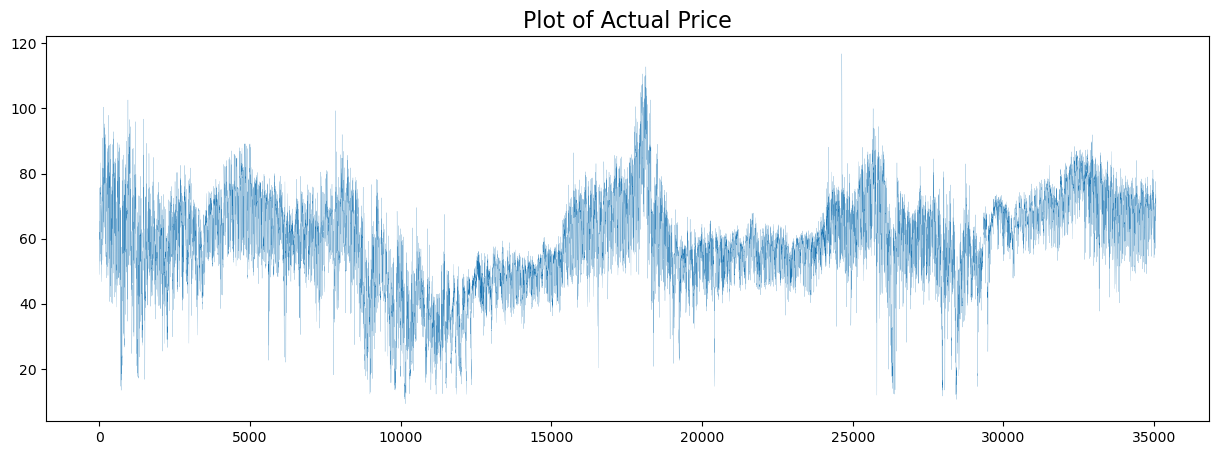

In [36]:
# Plot the feature of interest: 'price actual'. 
plt.figure(figsize=(15,5))
df['price actual'].plot(kind='line', lw=0.1)
plt.title('Plot of Actual Price', fontsize=16);

For simplicity of the analysis, I will focus on analysing and predicting the average price per day in year 2018.  The time information is then removed and only observations from the year 2018 are retained.

In [39]:
# Create a dataframe with the selected features. 
forecast_df= df[['time', 'price actual']]

In [40]:
forecast_df.head()

,time,price actual
0,2015-01-01 00:00:00,65.41
1,2015-01-01 01:00:00,64.92
2,2015-01-01 02:00:00,64.48
3,2015-01-01 03:00:00,59.32
4,2015-01-01 04:00:00,56.04


In [41]:
#Extract the year. 
forecast_df = forecast_df[forecast_df['time'].dt.year == 2018]

In [42]:
forecast_df.head()

,time,price actual
26304,2018-01-01 00:00:00,20.76
26305,2018-01-01 01:00:00,19.02
26306,2018-01-01 02:00:00,17.90
26307,2018-01-01 03:00:00,20.88
26308,2018-01-01 04:00:00,18.83


In [43]:
# Remove the time.
forecast_df['Date'] = forecast_df['time'].dt.date

In [44]:
forecast_df.head()

,time,price actual,Date
26304,2018-01-01 00:00:00,20.76,2018-01-01
26305,2018-01-01 01:00:00,19.02,2018-01-01
26306,2018-01-01 02:00:00,17.90,2018-01-01
26307,2018-01-01 03:00:00,20.88,2018-01-01
26308,2018-01-01 04:00:00,18.83,2018-01-01


In [45]:
# Group by date and find average price per day. 
forecast_df=forecast_df.groupby(['Date'])['price actual'].mean().reset_index()

In [46]:
forecast_df.shape

(365, 2)

In [47]:
# Set the date as index.
forecast_df.set_index('Date', inplace=True)


In [48]:
forecast_df = forecast_df.asfreq('D')  # Set frequency to daily ('D')

In [49]:
forecast_df.head()

,price actual
Date,
2018-01-01,21.042500
2018-01-02,47.864583
2018-01-03,46.862083
2018-01-04,44.930417
2018-01-05,50.742917


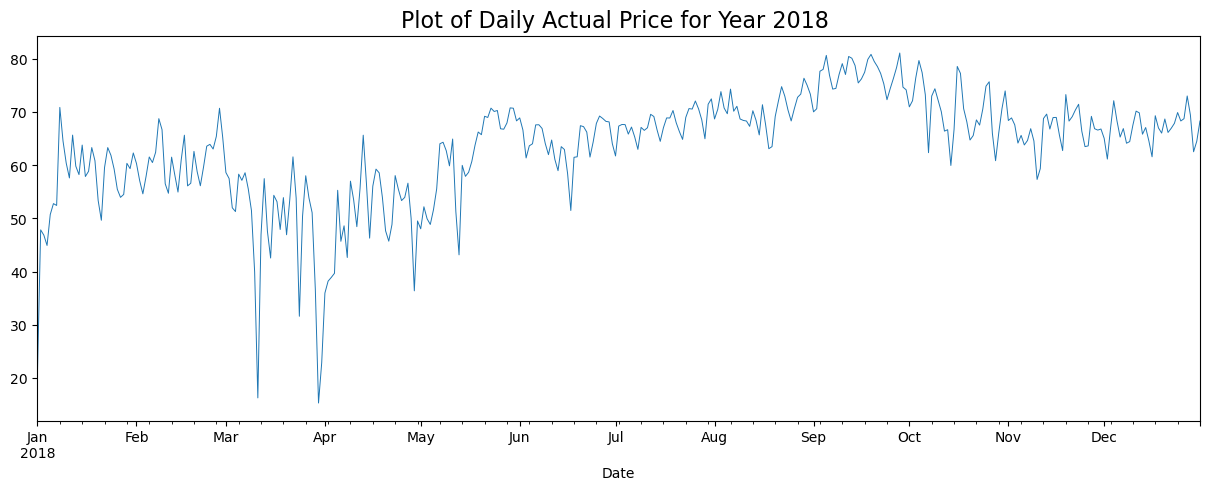

In [50]:
# Plot actual price. 
plt.figure(figsize=(15,5))
forecast_df['price actual'].plot(kind='line', lw=0.7)
plt.title('Plot of Daily Actual Price for Year 2018 ', fontsize=16);

In [16]:
#Check if the data is stationary. The data results non stationary.
adfuller(forecast_df["price actual"])

(-1.7514422332447552,
 0.4048215506882066,
 12,
 352,
 {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306},
 2062.6300937287706)

In [17]:
# Splitting the data into training and testing sets
train_size = 0.9  
train, test = train_test_split(forecast_df['price actual'], train_size=train_size, shuffle=False)


# Print the sizes of the training and testing sets
print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 328
Test set size: 37


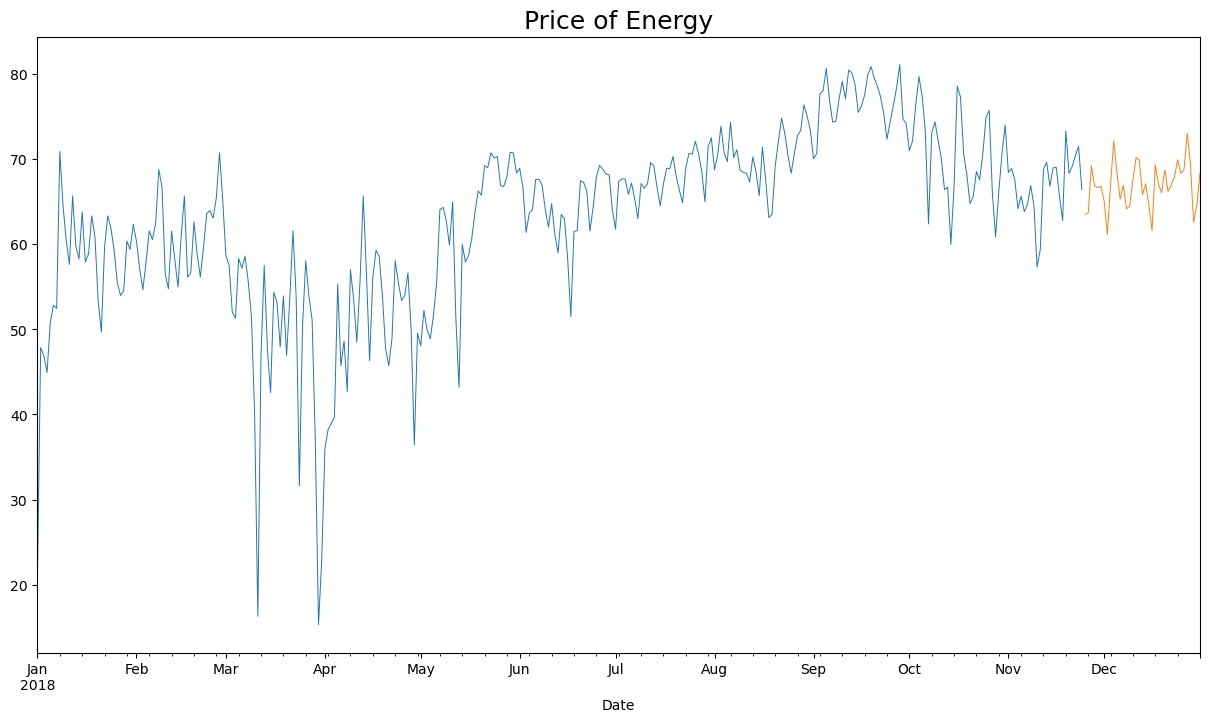

In [18]:
train.plot(figsize=(15,8), lw=0.7)
test.plot(figsize=(15,8), lw=0.7)
plt.title('Price of Energy', fontsize=18);

In [19]:
# Check stationarity also on the train set. The train set is non stationary. 
adfuller(train)

(-1.6281123382590308,
 0.46847894450353045,
 12,
 315,
 {'1%': -3.451281394993741,
  '5%': -2.8707595072926293,
  '10%': -2.571682118921643},
 1868.9096030592423)

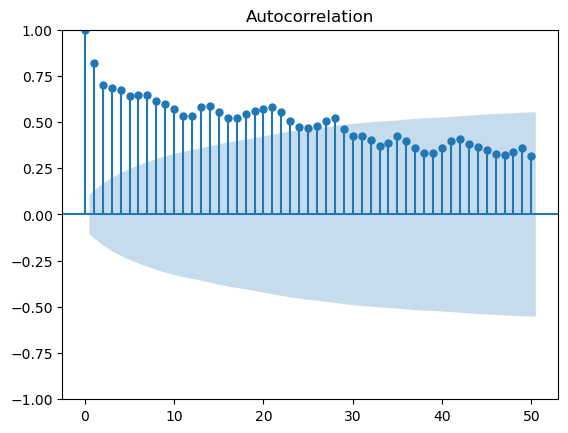

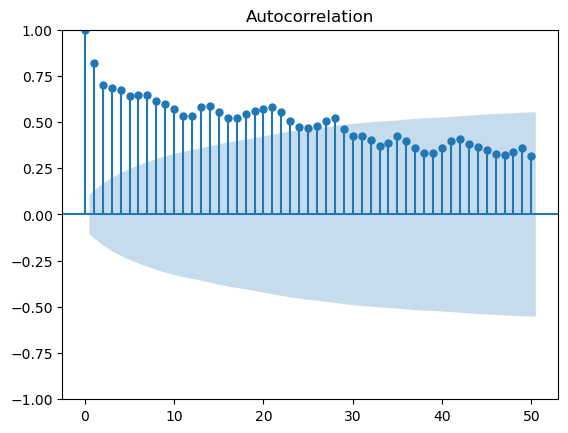

In [20]:
# Plot ACF. 
plot_acf(train, lags=50)

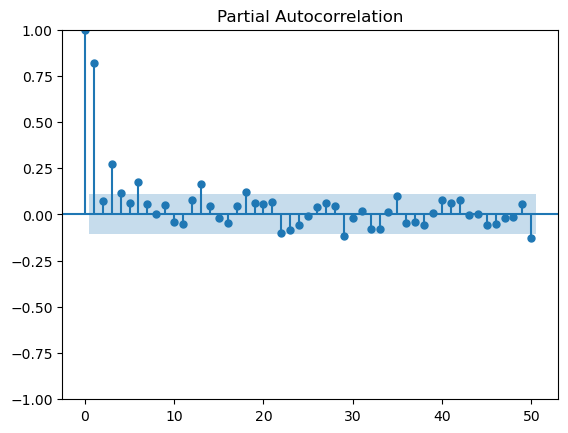

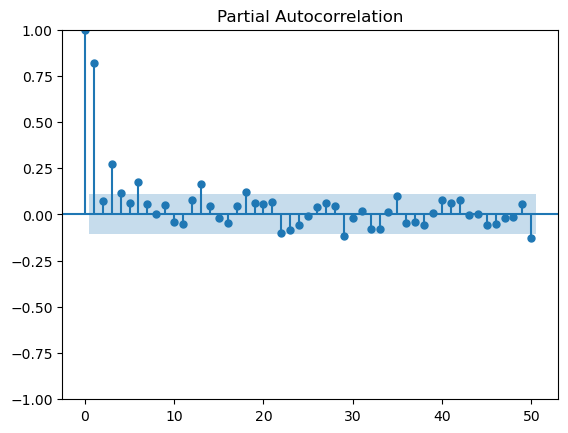

In [21]:
plot_pacf(train, method='ywm', lags=50)

In [22]:
# Check how the stationarity would be with 1 differentiation. 
adfuller(train.diff(1).dropna())

(-7.426375554834964,
 6.532345087273852e-11,
 11,
 315,
 {'1%': -3.451281394993741,
  '5%': -2.8707595072926293,
  '10%': -2.571682118921643},
 1864.1013785599669)

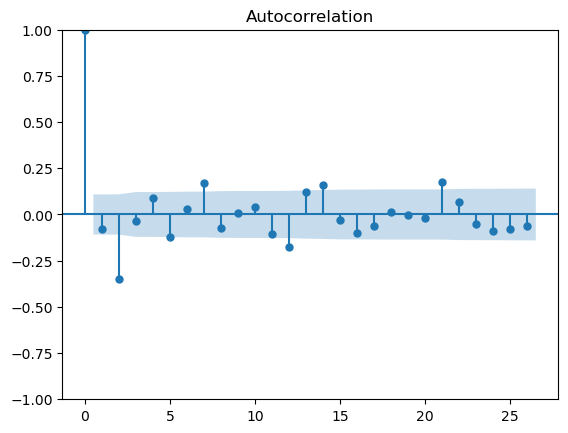

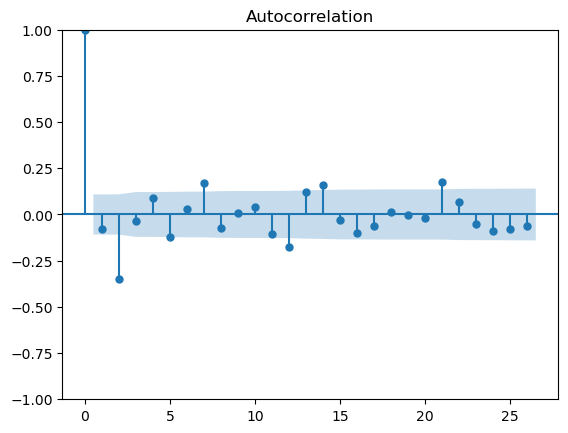

In [23]:
# Plot acf on differentiated train set. 
plot_acf(train.diff(1).dropna())

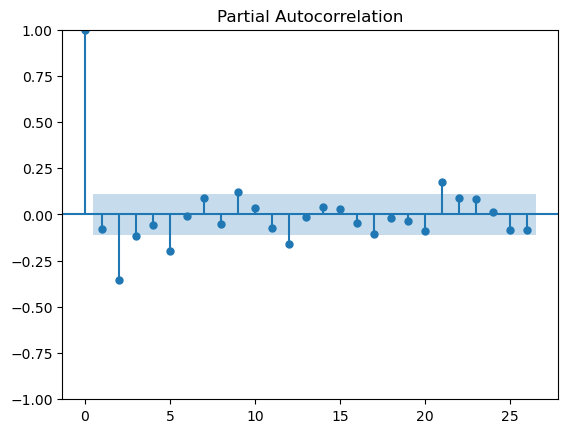

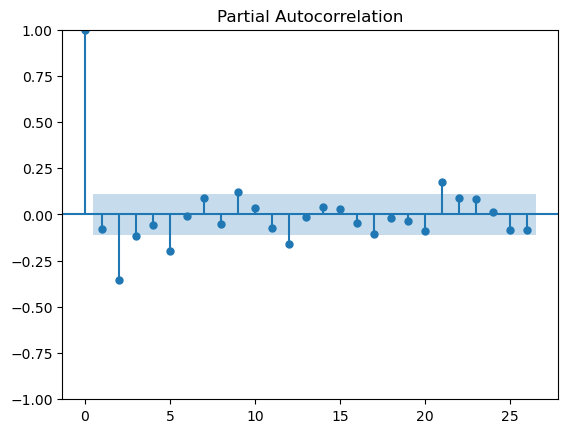

In [24]:
# Plot pacf on differentiated train set. 
plot_pacf(train.diff(1).dropna())

In [25]:
# Create a grid search for parameters in the SARIMA model.
aicVals = []
for p in range(4):
    for d in range(3):
        for q in range(4):
            for P in range(4): 
                for D in range(3):  
                    for Q in range(4):  
                        print(f"p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}")
                        try:
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 7))
                            results = model.fit()
                            aic = results.aic
                            aicVals.append([aic, p, d, q, P, D, Q])
                        except:
                            continue

p: 0, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 2, D: 2, Q: 3
p: 0, d: 0, q: 0, P: 3, D: 0, Q: 0
p: 0, d: 0, q: 0, P: 3, D: 0, Q: 1
p: 0, d: 0, q: 0, P: 3, D: 0, Q: 2
p: 0, d: 0, q: 0, P: 3, D: 0, Q: 3
p: 0, d: 0, q: 0, P: 3, D: 1, Q: 0
p: 0, d: 0, q: 0, P: 3, D: 1, Q: 1
p: 0, d: 0, q: 0, P: 3, D: 1, Q: 2
p: 0, d: 0, q: 0, P: 3, D: 1, Q: 3
p: 0, d: 0, q: 0, P: 3, D: 2, Q: 0
p: 0, d: 0, q: 0, P: 3, D: 2, Q: 1
p: 0, d: 0, q: 0, P: 3, D: 2, Q: 2
p: 0, d: 0, q: 0, P: 3, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 2, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 2, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 1, P: 2, D: 2, Q: 3
p: 0, d: 0, q: 1, P: 3, D: 0, Q: 0
p: 0, d: 0, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 3, D: 0, Q: 2
p: 0, d: 0, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 3, D: 1, Q: 0
p: 0, d: 0, q: 1, P: 3, D: 1, Q: 1
p: 0, d: 0, q: 1, P: 3, D: 1, Q: 2
p: 0, d: 0, q: 1, P: 3, D: 1, Q: 3
p: 0, d: 0, q: 1, P: 3, D: 2, Q: 0
p: 0, d: 0, q: 1, P: 3, D: 2, Q: 1
p: 0, d: 0, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 0, Q: 3
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 0, Q: 3
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 2, D: 2, Q: 2
p: 0, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 3, D: 0, Q: 1
p: 0, d: 0, q: 2, P: 3, D: 0, Q: 2
p: 0, d: 0, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 3, D: 1, Q: 0
p: 0, d: 0, q: 2, P: 3, D: 1, Q: 1
p: 0, d: 0, q: 2, P: 3, D: 1, Q: 2
p: 0, d: 0, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 3, D: 2, Q: 0
p: 0, d: 0, q: 2, P: 3, D: 2, Q: 1
p: 0, d: 0, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 2
p: 0, d: 0, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 2
p: 0, d: 0, q: 3, P: 0, D: 2, Q: 3
p: 0, d: 0, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 1, D: 1, Q: 3
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 1, D: 2, Q: 3
p: 0, d: 0, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 0, Q: 3
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 0, Q: 0
p: 0, d: 0, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 1, Q: 0
p: 0, d: 0, q: 3, P: 3, D: 1, Q: 1
p: 0, d: 0, q: 3, P: 3, D: 1, Q: 2
p: 0, d: 0, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 2, Q: 0
p: 0, d: 0, q: 3, P: 3, D: 2, Q: 1
p: 0, d: 0, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 0, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 0, P: 1, D: 2, Q: 2
p: 0, d: 1, q: 0, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 0, P: 2, D: 0, Q: 1
p: 0, d: 1, q: 0, P: 2, D: 0, Q: 2
p: 0, d: 1, q: 0, P: 2, D: 0, Q: 3
p: 0, d: 1, q: 0, P:

C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 0, P: 3, D: 0, Q: 3
p: 0, d: 1, q: 0, P: 3, D: 1, Q: 0
p: 0, d: 1, q: 0, P: 3, D: 1, Q: 1
p: 0, d: 1, q: 0, P: 3, D: 1, Q: 2
p: 0, d: 1, q: 0, P: 3, D: 1, Q: 3
p: 0, d: 1, q: 0, P: 3, D: 2, Q: 0
p: 0, d: 1, q: 0, P: 3, D: 2, Q: 1
p: 0, d: 1, q: 0, P: 3, D: 2, Q: 2
p: 0, d: 1, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 2
p: 0, d: 1, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 2
p: 0, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 2, D: 2, Q: 2
p: 0, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 3, D: 0, Q: 0
p: 0, d: 1, q: 1, P: 3, D: 0, Q: 1
p: 0, d: 1, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 3, D: 1, Q: 0
p: 0, d: 1, q: 1, P: 3, D: 1, Q: 1
p: 0, d: 1, q: 1, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 1, P: 3, D: 1, Q: 3
p: 0, d: 1, q: 1, P: 3, D: 2, Q: 0
p: 0, d: 1, q: 1, P: 3, D: 2, Q: 1
p: 0, d: 1, q: 1, P: 3, D: 2, Q: 2
p: 0, d: 1, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 1, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 1, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 0, Q: 3
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 2, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 2, D: 2, Q: 3
p: 0, d: 1, q: 2, P: 3, D: 0, Q: 0
p: 0, d: 1, q: 2, P: 3, D: 0, Q: 1
p: 0, d: 1, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 2, P: 3, D: 1, Q: 0
p: 0, d: 1, q: 2, P: 3, D: 1, Q: 1
p: 0, d: 1, q: 2, P: 3, D: 1, Q: 2
p: 0, d: 1, q: 2, P: 3, D: 1, Q: 3
p: 0, d: 1, q: 2, P: 3, D: 2, Q: 0
p: 0, d: 1, q: 2, P: 3, D: 2, Q: 1
p: 0, d: 1, q: 2, P: 3, D: 2, Q: 2
p: 0, d: 1, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 2
p: 0, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 2
p: 0, d: 1, q: 3, P: 1, D: 2, Q: 3
p: 0, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 1, Q: 3
p: 0, d: 1, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 3, D: 0, Q: 0
p: 0, d: 1, q: 3, P: 3, D: 0, Q: 1
p: 0, d: 1, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 3, D: 0, Q: 3
p: 0, d: 1, q: 3, P: 3, D: 1, Q: 0
p: 0, d: 1, q: 3, P: 3, D: 1, Q: 1
p: 0, d: 1, q: 3, P: 3, D: 1, Q: 2
p: 0, d: 1, q: 3, P: 3, D: 1, Q: 3
p: 0, d: 1, q: 3, P: 3, D: 2, Q: 0
p: 0, d: 1, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 1, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 2, D: 2, Q: 3
p: 0, d: 2, q: 0, P: 3, D: 0, Q: 0
p: 0, d: 2, q: 0, P: 3, D: 0, Q: 1
p: 0, d: 2, q: 0, P: 3, D: 0, Q: 2
p: 0, d: 2, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 0, P: 3, D: 1, Q: 0
p: 0, d: 2, q: 0, P: 3, D: 1, Q: 1
p: 0, d: 2, q: 0, P: 3, D: 1, Q: 2
p: 0, d: 2, q: 0, P: 3, D: 1, Q: 3
p: 0, d: 2, q: 0, P: 3, D: 2, Q: 0
p: 0, d: 2, q: 0, P: 3, D: 2, Q: 1
p: 0, d: 2, q: 0, P: 3, D: 2, Q: 2
p: 0, d: 2, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 1, P: 2, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 2, D: 1, Q: 3
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 3, D: 0, Q: 0
p: 0, d: 2, q: 1, P: 3, D: 0, Q: 1
p: 0, d: 2, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 3, D: 0, Q: 3
p: 0, d: 2, q: 1, P: 3, D: 1, Q: 0
p: 0, d: 2, q: 1, P: 3, D: 1, Q: 1
p: 0, d: 2, q: 1, P: 3, D: 1, Q: 2
p: 0, d: 2, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 1, P: 3, D: 2, Q: 0
p: 0, d: 2, q: 1, P: 3, D: 2, Q: 1
p: 0, d: 2, q: 1, P: 3, D: 2, Q: 2
p: 0, d: 2, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 0, D: 2, Q: 3
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 1, D: 2, Q: 3
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 3, D: 0, Q: 0
p: 0, d: 2, q: 2, P: 3, D: 0, Q: 1
p: 0, d: 2, q: 2, P: 3, D: 0, Q: 2
p: 0, d: 2, q: 2, P: 3, D: 0, Q: 3
p: 0, d: 2, q: 2, P: 3, D: 1, Q: 0
p: 0, d: 2, q: 2, P: 3, D: 1, Q: 1
p: 0, d: 2, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 2, P: 3, D: 2, Q: 0
p: 0, d: 2, q: 2, P: 3, D: 2, Q: 1
p: 0, d: 2, q: 2, P: 3, D: 2, Q: 2
p: 0, d: 2, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 0, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 0, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 2
p: 0, d: 2, q: 3, P: 0, D: 1, Q: 3
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 2
p: 0, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 1, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 1, Q: 3
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 2
p: 0, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 1, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 2, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 2
p: 0, d: 2, q: 3, P: 2, D: 2, Q: 3
p: 0, d: 2, q: 3, P: 3, D: 0, Q: 0
p: 0, d: 2, q: 3, P: 3, D: 0, Q: 1
p: 0, d: 2, q: 3, P: 3, D: 0, Q: 2
p: 0, d: 2, q: 3, P: 3, D: 0, Q: 3
p: 0, d: 2, q: 3, P: 3, D: 1, Q: 0
p: 0, d: 2, q: 3, P: 3, D: 1, Q: 1
p: 0, d: 2, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 3, D: 2, Q: 0
p: 0, d: 2, q: 3, P: 3, D: 2, Q: 1
p: 0, d: 2, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0, d: 2, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 0, q: 0, P: 0, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 1, d: 0, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 0, Q: 2
p: 1, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 1, d: 0, q: 0, P: 2, D: 2, Q: 3
p: 1, d: 0, q: 0, P: 3, D: 0, Q: 0
p: 1, d: 0, q: 0, P: 3, D: 0, Q: 1
p: 1, d: 0, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 3, D: 1, Q: 0
p: 1, d: 0, q: 0, P: 3, D: 1, Q: 1
p: 1, d: 0, q: 0, P: 3, D: 1, Q: 2
p: 1, d: 0, q: 0, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 3, D: 2, Q: 0
p: 1, d: 0, q: 0, P: 3, D: 2, Q: 1
p: 1, d: 0, q: 0, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 0, D: 2, Q: 3
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 1, D: 0, Q: 3
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 1, D: 2, Q: 2
p: 1, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 2, D: 0, Q: 3
p: 1, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 0, q: 1, P: 2, D: 2, Q: 2
p: 1, d: 0, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 3, D: 0, Q: 0
p: 1, d: 0, q: 1, P: 3, D: 0, Q: 1
p: 1, d: 0, q: 1, P: 3, D: 0, Q: 2
p: 1, d: 0, q: 1, P: 3, D: 0, Q: 3
p: 1, d: 0, q: 1, P: 3, D: 1, Q: 0
p: 1, d: 0, q: 1, P: 3, D: 1, Q: 1
p: 1, d: 0, q: 1, P: 3, D: 1, Q: 2
p: 1, d: 0, q: 1, P: 3, D: 1, Q: 3
p: 1, d: 0, q: 1, P: 3, D: 2, Q: 0
p: 1, d: 0, q: 1, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 2, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 1, D: 0, Q: 3
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 1, D: 1, Q: 3
p: 1, d: 0, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 0, Q: 0
p: 1, d: 0, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 0, Q: 2
p: 1, d: 0, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 1, Q: 0
p: 1, d: 0, q: 2, P: 3, D: 1, Q: 1
p: 1, d: 0, q: 2, P: 3, D: 1, Q: 2
p: 1, d: 0, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 2, Q: 0
p: 1, d: 0, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 2
p: 1, d: 0, q: 3, P: 0, D: 0, Q: 3
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 1, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 1
p: 1, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 0, Q: 1
p: 1, d: 0, q: 3, P: 1, D: 0, Q: 2
p: 1, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 1, Q: 3
p: 1, d: 0, q: 3, P: 2, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 2, D: 2, Q: 2
p: 1, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 0, Q: 0
p: 1, d: 0, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 0, Q: 2
p: 1, d: 0, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 1, Q: 0
p: 1, d: 0, q: 3, P: 3, D: 1, Q: 1
p: 1, d: 0, q: 3, P: 3, D: 1, Q: 2
p: 1, d: 0, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 2, Q: 0
p: 1, d: 0, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 0, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 2, D: 0, Q: 3
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 3, D: 0, Q: 0
p: 1, d: 1, q: 0, P: 3, D: 0, Q: 1
p: 1, d: 1, q: 0, P: 3, D: 0, Q: 2
p: 1, d: 1, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 0, P: 3, D: 1, Q: 0
p: 1, d: 1, q: 0, P: 3, D: 1, Q: 1
p: 1, d: 1, q: 0, P: 3, D: 1, Q: 2
p: 1, d: 1, q: 0, P: 3, D: 1, Q: 3
p: 1, d: 1, q: 0, P: 3, D: 2, Q: 0
p: 1, d: 1, q: 0, P: 3, D: 2, Q: 1
p: 1, d: 1, q: 0, P: 3, D: 2, Q: 2
p: 1, d: 1, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 2
p: 1, d: 1, q: 1, P: 0, D: 2, Q: 3
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 1, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 1, D: 2, Q: 3
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 2
p: 1, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 2, D: 2, Q: 2
p: 1, d: 1, q: 1, P: 2, D: 2, Q: 3
p: 1, d: 1, q: 1, P: 3, D: 0, Q: 0
p: 1, d: 1, q: 1, P: 3, D: 0, Q: 1
p: 1, d: 1, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 3, D: 1, Q: 0
p: 1, d: 1, q: 1, P: 3, D: 1, Q: 1
p: 1, d: 1, q: 1, P: 3, D: 1, Q: 2
p: 1, d: 1, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 1, P: 3, D: 2, Q: 0
p: 1, d: 1, q: 1, P: 3, D: 2, Q: 1
p: 1, d: 1, q: 1, P: 3, D: 2, Q: 2
p: 1, d: 1, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 2
p: 1, d: 1, q: 2, P: 1, D: 1, Q: 3
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 2, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 2, D: 2, Q: 3
p: 1, d: 1, q: 2, P: 3, D: 0, Q: 0
p: 1, d: 1, q: 2, P: 3, D: 0, Q: 1
p: 1, d: 1, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 2, P: 3, D: 1, Q: 0
p: 1, d: 1, q: 2, P: 3, D: 1, Q: 1
p: 1, d: 1, q: 2, P: 3, D: 1, Q: 2
p: 1, d: 1, q: 2, P: 3, D: 1, Q: 3
p: 1, d: 1, q: 2, P: 3, D: 2, Q: 0
p: 1, d: 1, q: 2, P: 3, D: 2, Q: 1
p: 1, d: 1, q: 2, P: 3, D: 2, Q: 2
p: 1, d: 1, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 1, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 2
p: 1, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 2, Q: 1
p: 1, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 0, Q: 1
p: 1, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 1, d: 1, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 0, Q: 0
p: 1, d: 1, q: 3, P: 3, D: 0, Q: 1
p: 1, d: 1, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 1, Q: 0
p: 1, d: 1, q: 3, P: 3, D: 1, Q: 1
p: 1, d: 1, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 1, Q: 3
p: 1, d: 1, q: 3, P: 3, D: 2, Q: 0
p: 1, d: 1, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 1, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 2
p: 1, d: 2, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 1, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 2
p: 1, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 3, D: 0, Q: 0
p: 1, d: 2, q: 0, P: 3, D: 0, Q: 1
p: 1, d: 2, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 0, P: 3, D: 1, Q: 0
p: 1, d: 2, q: 0, P: 3, D: 1, Q: 1
p: 1, d: 2, q: 0, P: 3, D: 1, Q: 2
p: 1, d: 2, q: 0, P: 3, D: 1, Q: 3
p: 1, d: 2, q: 0, P: 3, D: 2, Q: 0
p: 1, d: 2, q: 0, P: 3, D: 2, Q: 1
p: 1, d: 2, q: 0, P: 3, D: 2, Q: 2
p: 1, d: 2, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 0, Q: 3
p: 1, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 1, Q: 3
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 1, D: 2, Q: 3
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 2, D: 0, Q: 3
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 2
p: 1, d: 2, q: 1, P: 2, D: 1, Q: 3
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 2, D: 2, Q: 3
p: 1, d: 2, q: 1, P: 3, D: 0, Q: 0
p: 1, d: 2, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 3, D: 0, Q: 2
p: 1, d: 2, q: 1, P: 3, D: 0, Q: 3
p: 1, d: 2, q: 1, P: 3, D: 1, Q: 0
p: 1, d: 2, q: 1, P: 3, D: 1, Q: 1
p: 1, d: 2, q: 1, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 1, P: 3, D: 2, Q: 0
p: 1, d: 2, q: 1, P: 3, D: 2, Q: 1
p: 1, d: 2, q: 1, P: 3, D: 2, Q: 2
p: 1, d: 2, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 1
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 2
p: 1, d: 2, q: 2, P: 0, D: 2, Q: 3
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 1, D: 2, Q: 1
p: 1, d: 2, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 1, d: 2, q: 2, P: 2, D: 0, Q: 2
p: 1, d: 2, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 1, Q: 3
p: 1, d: 2, q: 2, P: 2, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 2, D: 2, Q: 3
p: 1, d: 2, q: 2, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 1, Q: 0
p: 1, d: 2, q: 2, P: 3, D: 1, Q: 1
p: 1, d: 2, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 2, Q: 0
p: 1, d: 2, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 0, Q: 0
p: 1, d: 2, q: 3, P: 0, D: 0, Q: 1
p: 1, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 1, Q: 0
p: 1, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 1, d: 2, q: 3, P: 0, D: 1, Q: 2
p: 1, d: 2, q: 3, P: 0, D: 1, Q: 3
p: 1, d: 2, q: 3, P: 0, D: 2, Q: 0
p: 1, d: 2, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 0, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 0, Q: 2
p: 1, d: 2, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 1, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 1, Q: 3
p: 1, d: 2, q: 3, P: 1, D: 2, Q: 0
p: 1, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 0, Q: 2
p: 1, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 0
p: 1, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 0, Q: 1
p: 1, d: 2, q: 3, P: 3, D: 0, Q: 2
p: 1, d: 2, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 1, Q: 0
p: 1, d: 2, q: 3, P: 3, D: 1, Q: 1
p: 1, d: 2, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 1, d: 2, q: 3, P: 3, D: 2, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 0, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 2
p: 2, d: 0, q: 0, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 2, d: 0, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 2, d: 0, q: 0, P: 2, D: 2, Q: 3
p: 2, d: 0, q: 0, P: 3, D: 0, Q: 0
p: 2, d: 0, q: 0, P: 3, D: 0, Q: 1
p: 2, d: 0, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 3, D: 1, Q: 0
p: 2, d: 0, q: 0, P: 3, D: 1, Q: 1
p: 2, d: 0, q: 0, P: 3, D: 1, Q: 2
p: 2, d: 0, q: 0, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 3, D: 2, Q: 0
p: 2, d: 0, q: 0, P: 3, D: 2, Q: 1
p: 2, d: 0, q: 0, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 0, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 0, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 1, Q: 2
p: 2, d: 0, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 1, D: 2, Q: 3
p: 2, d: 0, q: 1, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 0, Q: 1
p: 2, d: 0, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 2, D: 2, Q: 2
p: 2, d: 0, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 0, Q: 0
p: 2, d: 0, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 1, Q: 0
p: 2, d: 0, q: 1, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 2, Q: 0
p: 2, d: 0, q: 1, P: 3, D: 2, Q: 1
p: 2, d: 0, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 2, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 2, Q: 0
p: 2, d: 0, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 1, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 1, D: 2, Q: 1
p: 2, d: 0, q: 2, P: 1, D: 2, Q: 2
p: 2, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 2, D: 1, Q: 1
p: 2, d: 0, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 0, Q: 0
p: 2, d: 0, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 1, Q: 0
p: 2, d: 0, q: 2, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 1, Q: 2
p: 2, d: 0, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 2, Q: 0
p: 2, d: 0, q: 2, P: 3, D: 2, Q: 1
p: 2, d: 0, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 2, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 2, d: 0, q: 3, P: 0, D: 0, Q: 2
p: 2, d: 0, q: 3, P: 0, D: 0, Q: 3
p: 2, d: 0, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 2, d: 0, q: 3, P: 0, D: 1, Q: 3
p: 2, d: 0, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 0, Q: 1
p: 2, d: 0, q: 3, P: 1, D: 0, Q: 2
p: 2, d: 0, q: 3, P: 1, D: 0, Q: 3
p: 2, d: 0, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 0
p: 2, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 0, Q: 2
p: 2, d: 0, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 2, d: 0, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 0, Q: 0
p: 2, d: 0, q: 3, P: 3, D: 0, Q: 1
p: 2, d: 0, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 1, Q: 0
p: 2, d: 0, q: 3, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 0, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 2, D: 0, Q: 3
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 2, d: 1, q: 0, P: 2, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 2
p: 2, d: 1, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 3, D: 0, Q: 0
p: 2, d: 1, q: 0, P: 3, D: 0, Q: 1
p: 2, d: 1, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 3, D: 1, Q: 0
p: 2, d: 1, q: 0, P: 3, D: 1, Q: 1
p: 2, d: 1, q: 0, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 0, P: 3, D: 1, Q: 3
p: 2, d: 1, q: 0, P: 3, D: 2, Q: 0
p: 2, d: 1, q: 0, P: 3, D: 2, Q: 1
p: 2, d: 1, q: 0, P: 3, D: 2, Q: 2
p: 2, d: 1, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 1, D: 1, Q: 3
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 2
p: 2, d: 1, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 2, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 3, D: 0, Q: 0
p: 2, d: 1, q: 1, P: 3, D: 0, Q: 1
p: 2, d: 1, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 1, P: 3, D: 1, Q: 0
p: 2, d: 1, q: 1, P: 3, D: 1, Q: 1
p: 2, d: 1, q: 1, P: 3, D: 1, Q: 2
p: 2, d: 1, q: 1, P: 3, D: 1, Q: 3
p: 2, d: 1, q: 1, P: 3, D: 2, Q: 0
p: 2, d: 1, q: 1, P: 3, D: 2, Q: 1
p: 2, d: 1, q: 1, P: 3, D: 2, Q: 2
p: 2, d: 1, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 1, q: 2, P: 0, D: 1, Q: 3
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 2, d: 1, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 2
p: 2, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 0, Q: 0
p: 2, d: 1, q: 2, P: 3, D: 0, Q: 1
p: 2, d: 1, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 0, Q: 3
p: 2, d: 1, q: 2, P: 3, D: 1, Q: 0
p: 2, d: 1, q: 2, P: 3, D: 1, Q: 1
p: 2, d: 1, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 2, Q: 0
p: 2, d: 1, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 2, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 2, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 0, Q: 3
p: 2, d: 1, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 0, Q: 0
p: 2, d: 1, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 1, Q: 0
p: 2, d: 1, q: 3, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 1, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 2, d: 2, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 1, D: 1, Q: 3
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 2
p: 2, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 1, Q: 3
p: 2, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 2, D: 2, Q: 3
p: 2, d: 2, q: 0, P: 3, D: 0, Q: 0
p: 2, d: 2, q: 0, P: 3, D: 0, Q: 1
p: 2, d: 2, q: 0, P: 3, D: 0, Q: 2
p: 2, d: 2, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 3, D: 1, Q: 0
p: 2, d: 2, q: 0, P: 3, D: 1, Q: 1
p: 2, d: 2, q: 0, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 3, D: 1, Q: 3
p: 2, d: 2, q: 0, P: 3, D: 2, Q: 0
p: 2, d: 2, q: 0, P: 3, D: 2, Q: 1
p: 2, d: 2, q: 0, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 0, P: 3, D: 2, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 2
p: 2, d: 2, q: 1, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 2, d: 2, q: 1, P: 1, D: 0, Q: 3
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 1, D: 2, Q: 2
p: 2, d: 2, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 0, Q: 3
p: 2, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 2, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 2, d: 2, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 0, Q: 0
p: 2, d: 2, q: 1, P: 3, D: 0, Q: 1
p: 2, d: 2, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 1, Q: 0
p: 2, d: 2, q: 1, P: 3, D: 1, Q: 1
p: 2, d: 2, q: 1, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 0, D: 0, Q: 3
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 2, d: 2, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 1, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 1, D: 0, Q: 3
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 2
p: 2, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 0, Q: 0
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 2, D: 0, Q: 3
p: 2, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 2, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 0, Q: 1
p: 2, d: 2, q: 2, P: 3, D: 0, Q: 2
p: 2, d: 2, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 1, Q: 0
p: 2, d: 2, q: 2, P: 3, D: 1, Q: 1
p: 2, d: 2, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 1, Q: 1
p: 2, d: 2, q: 3, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 1, Q: 2
p: 2, d: 2, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 2, d: 2, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 2
p: 3, d: 0, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 2
p: 3, d: 0, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 2, D: 0, Q: 3
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 0, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 2
p: 3, d: 0, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 3, D: 0, Q: 0
p: 3, d: 0, q: 0, P: 3, D: 0, Q: 1
p: 3, d: 0, q: 0, P: 3, D: 0, Q: 2
p: 3, d: 0, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 3, D: 1, Q: 0
p: 3, d: 0, q: 0, P: 3, D: 1, Q: 1
p: 3, d: 0, q: 0, P: 3, D: 1, Q: 2
p: 3, d: 0, q: 0, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 3, D: 2, Q: 0
p: 3, d: 0, q: 0, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 0, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 0, D: 2, Q: 3
p: 3, d: 0, q: 1, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 1, Q: 3
p: 3, d: 0, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 1, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 0, Q: 2
p: 3, d: 0, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 2, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 0, Q: 0
p: 3, d: 0, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 1, Q: 0
p: 3, d: 0, q: 1, P: 3, D: 1, Q: 1
p: 3, d: 0, q: 1, P: 3, D: 1, Q: 2
p: 3, d: 0, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 2, Q: 0
p: 3, d: 0, q: 1, P: 3, D: 2, Q: 1
p: 3, d: 0, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 2, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 2, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 0, Q: 0
p: 3, d: 0, q: 3, P: 0, D: 0, Q: 1
p: 3, d: 0, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 0, Q: 3
p: 3, d: 0, q: 3, P: 0, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 1, Q: 2
p: 3, d: 0, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 0, Q: 0
p: 3, d: 0, q: 3, P: 1, D: 0, Q: 1
p: 3, d: 0, q: 3, P: 1, D: 0, Q: 2
p: 3, d: 0, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 1, Q: 1
p: 3, d: 0, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 0, Q: 2
p: 3, d: 0, q: 3, P: 2, D: 0, Q: 3
p: 3, d: 0, q: 3, P: 2, D: 1, Q: 0
p: 3, d: 0, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 1, Q: 0
p: 3, d: 0, q: 3, P: 3, D: 1, Q: 1
p: 3, d: 0, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 0, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 2
p: 3, d: 1, q: 0, P: 0, D: 2, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 1, D: 0, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 2
p: 3, d: 1, q: 0, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 0, Q: 3
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 2
p: 3, d: 1, q: 0, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 3, D: 0, Q: 0
p: 3, d: 1, q: 0, P: 3, D: 0, Q: 1
p: 3, d: 1, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 3, D: 1, Q: 0
p: 3, d: 1, q: 0, P: 3, D: 1, Q: 1
p: 3, d: 1, q: 0, P: 3, D: 1, Q: 2
p: 3, d: 1, q: 0, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 0, P: 3, D: 2, Q: 0
p: 3, d: 1, q: 0, P: 3, D: 2, Q: 1
p: 3, d: 1, q: 0, P: 3, D: 2, Q: 2
p: 3, d: 1, q: 0, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 2
p: 3, d: 1, q: 1, P: 0, D: 2, Q: 3
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 0, Q: 2
p: 3, d: 1, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 1, Q: 3
p: 3, d: 1, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 1, D: 2, Q: 1
p: 3, d: 1, q: 1, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 0, Q: 0
p: 3, d: 1, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 0, Q: 2
p: 3, d: 1, q: 1, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 1, Q: 0
p: 3, d: 1, q: 1, P: 3, D: 1, Q: 1
p: 3, d: 1, q: 1, P: 3, D: 1, Q: 2
p: 3, d: 1, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 2, Q: 0
p: 3, d: 1, q: 1, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 2, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 0
p: 3, d: 1, q: 2, P: 0, D: 2, Q: 1
p: 3, d: 1, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 0, Q: 3
p: 3, d: 1, q: 2, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 1, D: 2, Q: 2
p: 3, d: 1, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 1, Q: 1
p: 3, d: 1, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 0
p: 3, d: 1, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 0, Q: 0
p: 3, d: 1, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 1, Q: 0
p: 3, d: 1, q: 2, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 2, Q: 0
p: 3, d: 1, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 1
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 2
p: 3, d: 1, q: 3, P: 0, D: 0, Q: 3
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 0
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 1
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 2
p: 3, d: 1, q: 3, P: 0, D: 1, Q: 3
p: 3, d: 1, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 0, Q: 0
p: 3, d: 1, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 1, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 0, Q: 3
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 1, Q: 3
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 2
p: 3, d: 2, q: 0, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 1, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 0, P: 1, D: 0, Q: 3
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 1, D: 1, Q: 3
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 1, D: 2, Q: 3
p: 3, d: 2, q: 0, P: 2, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 2, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 2
p: 3, d: 2, q: 0, P: 2, D: 2, Q: 3
p: 3, d: 2, q: 0, P: 3, D: 0, Q: 0
p: 3, d: 2, q: 0, P: 3, D: 0, Q: 1
p: 3, d: 2, q: 0, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 3, D: 1, Q: 0
p: 3, d: 2, q: 0, P: 3, D: 1, Q: 1
p: 3, d: 2, q: 0, P: 3, D: 1, Q: 2
p: 3, d: 2, q: 0, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 0, P: 3, D: 2, Q: 0
p: 3, d: 2, q: 0, P: 3, D: 2, Q: 1
p: 3, d: 2, q: 0, P: 3, D: 2, Q: 2
p: 3, d: 2, q: 0, P: 3, D: 2, Q: 3
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 2
p: 3, d: 2, q: 1, P: 0, D: 0, Q: 3
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 1, P: 0, D: 1, Q: 3
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 0, D: 2, Q: 3
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 1, P: 1, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 2
p: 3, d: 2, q: 1, P: 1, D: 1, Q: 3
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 2
p: 3, d: 2, q: 1, P: 1, D: 2, Q: 3
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 2, D: 2, Q: 3
p: 3, d: 2, q: 1, P: 3, D: 0, Q: 0
p: 3, d: 2, q: 1, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 3, D: 0, Q: 3
p: 3, d: 2, q: 1, P: 3, D: 1, Q: 0
p: 3, d: 2, q: 1, P: 3, D: 1, Q: 1
p: 3, d: 2, q: 1, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 3, D: 2, Q: 0
p: 3, d: 2, q: 1, P: 3, D: 2, Q: 1
p: 3, d: 2, q: 1, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 1, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 1
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 2, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 0
p: 3, d: 2, q: 2, P: 0, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 0, Q: 2
p: 3, d: 2, q: 2, P: 1, D: 0, Q: 3
p: 3, d: 2, q: 2, P: 1, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 1, D: 1, Q: 1
p: 3, d: 2, q: 2, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 0, Q: 1
p: 3, d: 2, q: 2, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 0, Q: 0
p: 3, d: 2, q: 2, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 0, Q: 3
p: 3, d: 2, q: 2, P: 3, D: 1, Q: 0
p: 3, d: 2, q: 2, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 2, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 1, Q: 0
p: 3, d: 2, q: 3, P: 0, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 1, Q: 2
p: 3, d: 2, q: 3, P: 0, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 1
p: 3, d: 2, q: 3, P: 0, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 0, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 0
p: 3, d: 2, q: 3, P: 1, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 0, Q: 3
p: 3, d: 2, q: 3, P: 1, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 1, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 2, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 0, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 0, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 0, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 0, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 1, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 1, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 1, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 1, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 2, Q: 0


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 2, Q: 1


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 2, Q: 2


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3, d: 2, q: 3, P: 3, D: 2, Q: 3


C:\Users\erica\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
aicVals.sort()

In [29]:
aicVals

[[10.0, 0, 1, 0, 2, 2, 2],
 [14.0, 1, 2, 3, 1, 0, 1],
 [14.0, 2, 0, 0, 2, 1, 2],
 [18.0, 2, 2, 0, 3, 2, 3],
 [99.50471312527247, 1, 0, 1, 1, 0, 0],
 [173.81409755692607, 3, 0, 0, 1, 0, 0],
 [325.75497758769035, 1, 0, 0, 1, 0, 0],
 [402.7734307587183, 0, 0, 2, 3, 0, 3],
 [886.3925277095152, 0, 1, 1, 3, 1, 2],
 [929.4642028545018, 2, 0, 0, 1, 0, 0],
 [1930.4932714172774, 3, 1, 3, 2, 1, 1],
 [1930.5485464765334, 3, 1, 3, 0, 1, 2],
 [1930.6928427109433, 2, 1, 3, 2, 1, 1],
 [1930.8886809486808, 3, 1, 3, 0, 1, 3],
 [1931.3309449509284, 2, 1, 3, 0, 1, 3],
 [1931.4173821933548, 2, 1, 3, 0, 1, 2],
 [1931.8289949237897, 3, 1, 0, 2, 1, 1],
 [1932.2419864959452, 2, 1, 1, 2, 1, 1],
 [1932.330366633292, 3, 1, 0, 0, 1, 3],
 [1932.3950267982186, 3, 1, 3, 3, 1, 1],
 [1932.5262229999278, 2, 1, 3, 3, 1, 1],
 [1932.7055366092548, 2, 1, 1, 0, 1, 3],
 [1932.7055520880667, 3, 1, 3, 1, 1, 1],
 [1932.9114246297504, 2, 1, 3, 2, 1, 2],
 [1933.000955106715, 3, 1, 3, 1, 1, 3],
 [1933.404830085879, 3, 1, 1, 2, 1, 1

In [133]:
model = SARIMAX(train, order=(3, 1, 0), seasonal_order=(0, 1, 3, 7)).fit()

In [134]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                              price actual   No. Observations:                  328
Model:             SARIMAX(3, 1, 0)x(0, 1, [1, 2, 3], 7)   Log Likelihood                -959.165
Date:                                   Mon, 20 Nov 2023   AIC                           1932.330
Time:                                           00:33:10   BIC                           1958.709
Sample:                                       01-01-2018   HQIC                          1942.864
                                            - 11-24-2018                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1734      0.035     -4.896      0.000      -0.243      -0.104
ar.L2         -0.4087      0.045     -9.140      0.000      -0.496      -0.321
ar.L3         -0.1416      0.057     -2.490      0.013      -0.253      -0.030
ma.S.L7       -1.0239      0.051    -20.274      0.000      -1.123      -0.925
ma.S.L14      -0.1066      0.061     -1.737      0.082      -0.227       0.014
ma.S.L21       0.1799      0.048      3.743      0.000       0.086       0.274
sigma2        22.1178      1.097     20.154      0.000      19.967      24.269
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               514.96
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
forecast_values = model.get_forecast(steps=test.shape[0])

In [136]:
forecast_values

In [137]:
forecast_ci = forecast_values.conf_int()

In [138]:
forecast_values.predicted_mean

2018-11-25    63.312620
2018-11-26    68.008116
2018-11-27    69.550906
2018-11-28    70.440561
2018-11-29    69.836125
2018-11-30    68.861536
2018-12-01    65.475058
2018-12-02    63.638632
2018-12-03    67.686846
2018-12-04    69.593836
2018-12-05    70.284878
2018-12-06    69.958449
2018-12-07    68.853110
2018-12-08    65.614122
2018-12-09    63.703184
2018-12-10    68.699945
2018-12-11    69.384356
2018-12-12    70.089005
2018-12-13    70.134974
2018-12-14    69.353024
2018-12-15    65.672137
2018-12-16    63.652926
2018-12-17    68.803253
2018-12-18    69.567863
2018-12-19    70.211182
2018-12-20    70.213264
2018-12-21    69.452629
2018-12-22    65.794666
2018-12-23    63.768985
2018-12-24    68.908047
2018-12-25    69.674008
2018-12-26    70.322613
2018-12-27    70.324822
2018-12-28    69.561813
2018-12-29    65.903462
2018-12-30    63.878800
2018-12-31    69.018180
Freq: D, Name: predicted_mean, dtype: float64

In [139]:
test

Date
2018-11-25    63.513750
2018-11-26    63.646250
2018-11-27    69.200417
2018-11-28    66.877083
2018-11-29    66.618750
2018-11-30    66.821250
2018-12-01    65.078333
2018-12-02    61.170833
2018-12-03    66.997917
2018-12-04    72.138333
2018-12-05    68.388333
2018-12-06    65.302917
2018-12-07    66.904167
2018-12-08    64.147917
2018-12-09    64.458750
2018-12-10    67.564167
2018-12-11    70.183333
2018-12-12    69.857917
2018-12-13    65.842917
2018-12-14    67.099167
2018-12-15    64.576250
2018-12-16    61.600417
2018-12-17    69.316250
2018-12-18    67.021667
2018-12-19    66.053333
2018-12-20    68.702500
2018-12-21    66.175833
2018-12-22    66.958333
2018-12-23    67.889583
2018-12-24    69.920000
2018-12-25    68.330000
2018-12-26    68.763750
2018-12-27    73.029583
2018-12-28    69.457083
2018-12-29    62.544583
2018-12-30    64.524583
2018-12-31    68.322083
Freq: D, Name: price actual, dtype: float64

In [158]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error


In [140]:
r2_score(forecast_values.predicted_mean, test)

0.04012058997157686

In [141]:
mean_squared_error(forecast_values.predicted_mean, test)

5.471443311845387

In [159]:
mean_absolute_error(forecast_values.predicted_mean, test)

1.9224178479749876

In [160]:
np.sqrt(mean_squared_error(forecast_values.predicted_mean, test))

2.3391116501452824

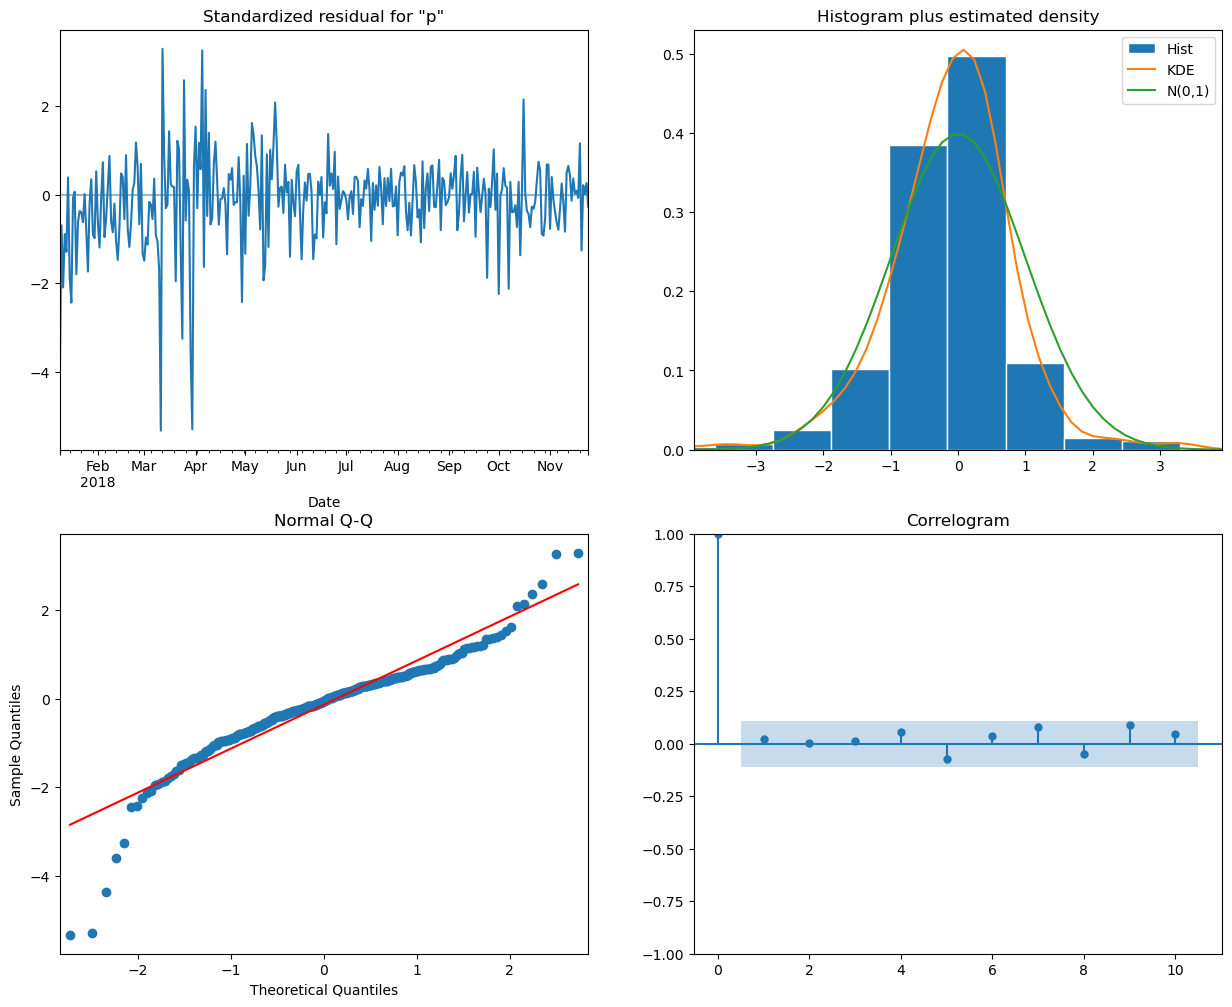

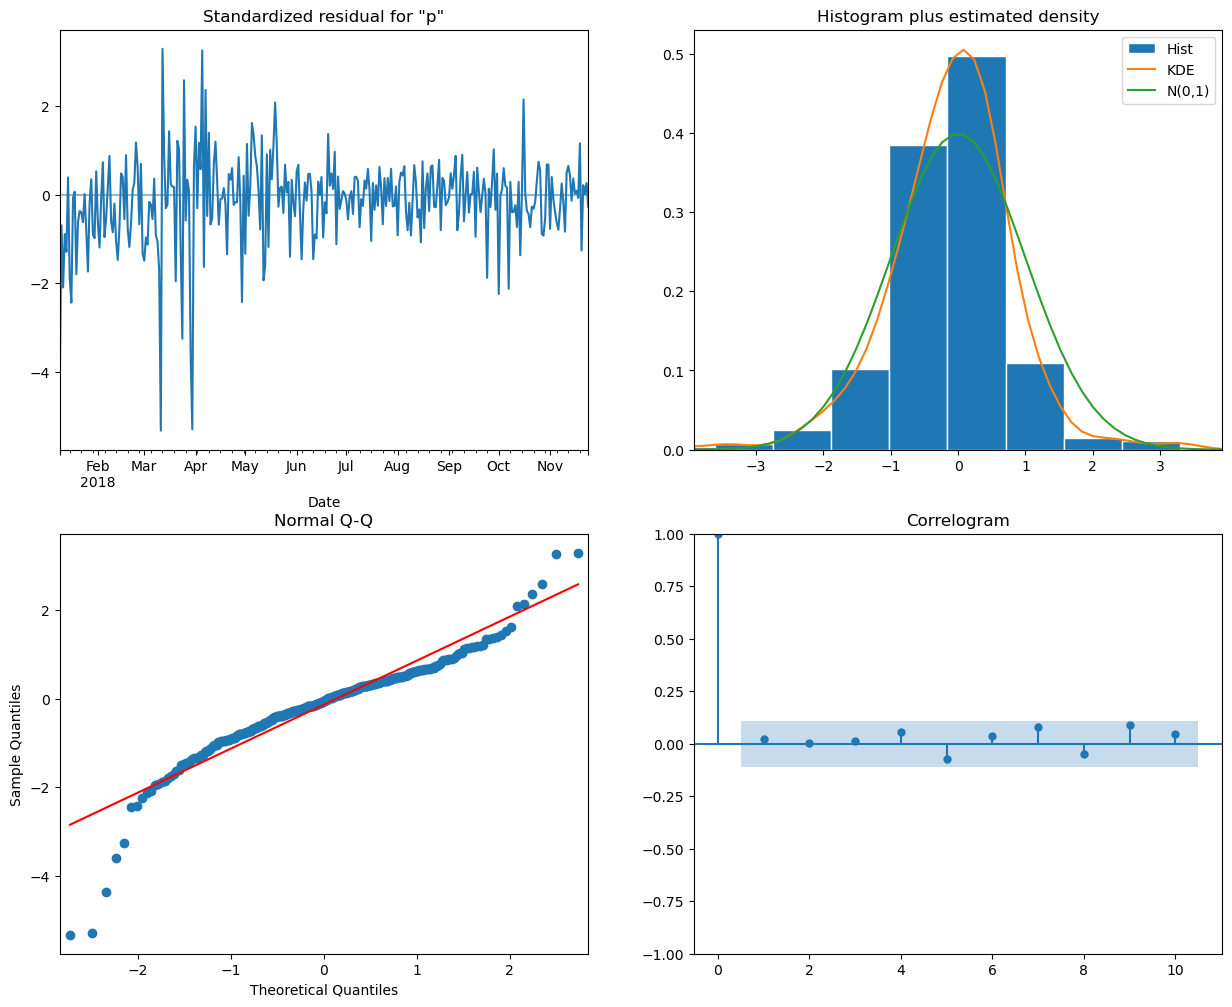

In [142]:
model.plot_diagnostics(figsize=(15, 12))

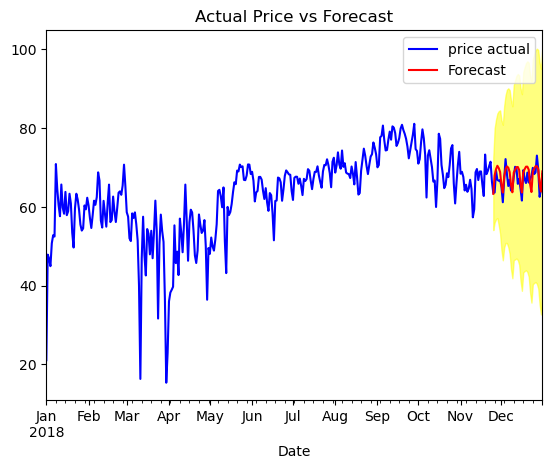

In [145]:
ax1 = forecast_df.plot(y="price actual", color="blue")
forecast_values.predicted_mean.plot(ax = ax1, label="Forecast", color='red')

ax1.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="yellow",
    alpha=0.5
)

ax1.legend()  # Add legend using the labels set in the plot commands
ax1.set_title("Actual Price vs Forecast")  # Set plot title

plt.show();

**Compare predicted and true values for the last 10 observations**

In [162]:
# Pick the last 10 observations from  of the data. 
val_10_tail = test.tail(10)  


In [163]:
val_10_tail.head(10)

Date
2018-12-22    66.958333
2018-12-23    67.889583
2018-12-24    69.920000
2018-12-25    68.330000
2018-12-26    68.763750
2018-12-27    73.029583
2018-12-28    69.457083
2018-12-29    62.544583
2018-12-30    64.524583
2018-12-31    68.322083
Freq: D, Name: price actual, dtype: float64

In [164]:
# Retrieve the last 10 predicted values
predictions = forecast_values.predicted_mean

last_10_predictions = predictions[-10:]
last_10_predictions

2018-12-22    65.794666
2018-12-23    63.768985
2018-12-24    68.908047
2018-12-25    69.674008
2018-12-26    70.322613
2018-12-27    70.324822
2018-12-28    69.561813
2018-12-29    65.903462
2018-12-30    63.878800
2018-12-31    69.018180
Freq: D, Name: predicted_mean, dtype: float64

In [165]:
# Evaluate the last 10 predictions with R^2
r2_score(last_10_predictions, val_10_tail)

0.2961154780219999

In [166]:
# Evaluate the last 10 predictions with MSE. 
mean_squared_error(last_10_predictions, val_10_tail)

4.310426398295769

In [167]:
 mean_absolute_error(val_10_tail, last_10_predictions)

1.6709338561774736

In [168]:
np.sqrt(mean_squared_error(val_10_tail, last_10_predictions))

2.0761566410788395

Compare these results with predictions and true values from the first 10 values of the test set. 

In [152]:
val_10_head=test.head(10) 
val_10_head

Date
2018-11-25    63.513750
2018-11-26    63.646250
2018-11-27    69.200417
2018-11-28    66.877083
2018-11-29    66.618750
2018-11-30    66.821250
2018-12-01    65.078333
2018-12-02    61.170833
2018-12-03    66.997917
2018-12-04    72.138333
Freq: D, Name: price actual, dtype: float64

In [154]:
# Retrieve first 10 predictions.
first_10_predictions = predictions[:10]
first_10_predictions

2018-11-25    63.312620
2018-11-26    68.008116
2018-11-27    69.550906
2018-11-28    70.440561
2018-11-29    69.836125
2018-11-30    68.861536
2018-12-01    65.475058
2018-12-02    63.638632
2018-12-03    67.686846
2018-12-04    69.593836
Freq: D, Name: predicted_mean, dtype: float64

In [155]:
# Evaluate the first 10 predictions with R^2
r2_score(first_10_predictions, val_10_head)

0.02599822410909791

In [156]:
# Evaluate the last 10 predictions with MSE. 
mean_squared_error(first_10_predictions, val_10_head)

5.959832064460281

In [169]:
mean_absolute_error(val_10_head, first_10_predictions)


1.983257311055081

In [170]:
 np.sqrt(mean_squared_error(val_10_head, first_10_predictions))

2.4412767283657706

# Text Analysis: analyse COP26 tweets. 

In [3]:
# Load the dataset. 
df2=pd.read_csv('COP26_tweets.csv')

In [4]:
df2.head()

,tweetURL,tweetID,date,tweetContent,userLocation,isUserVerified,replyCount,retweetCount,likeCount,quoteCount,tweetLanguage,sourceLabel,coordinates,place
0,https://twitter.com/thomascheneygpc/status/146...,1461120800350621700,2021-11-17T23:55:19+00:00,@sjmuir Why I like local Renewable Natural Gas...,NaN,False,0,0,0,0,en,Twitter for iPhone,NaN,NaN
1,https://twitter.com/alexizawadzki/status/14611...,1461118744613187585,2021-11-17T23:47:09+00:00,Nevada is critical towards the clean energy tr...,Greater Vancouver,False,0,1,21,0,en,Twitter for iPhone,NaN,NaN
2,https://twitter.com/getiftech/status/146111665...,1461116656986599433,2021-11-17T23:38:51+00:00,COP26 Net Zero Commitments will Speed Energy T...,NaN,False,0,0,0,0,en,TekieBoard,NaN,NaN
3,https://twitter.com/KirkMMorrison/status/14611...,1461114703636140042,2021-11-17T23:31:06+00:00,@alanfryermedia You’re onto something! 🇨🇦 has ...,"Calgary, Alberta",False,0,1,5,0,en,Twitter for iPhone,NaN,NaN
4,https://twitter.com/ColumbiaUEnergy/status/146...,1461114427466346499,2021-11-17T23:30:00+00:00,"""The reality is that actions in this decade wi...","New York, New York",True,0,1,3,1,en,Twitter for Advertisers.,NaN,NaN


In [5]:
# Select the column of interest: tweet content.
tweet=df2['tweetContent']

#Transform it in a pandas dataframe. 
tweet_df = pd.DataFrame(tweet, columns=['tweetContent'])

In [6]:
tweet_df.head()

,tweetContent
0,@sjmuir Why I like local Renewable Natural Gas...
1,Nevada is critical towards the clean energy tr...
2,COP26 Net Zero Commitments will Speed Energy T...
3,@alanfryermedia You’re onto something! 🇨🇦 has ...
4,"""The reality is that actions in this decade wi..."


**Data Cleaning and Preprocessing**

In [7]:
# Rename the tweet column. 
tweet_df.rename(columns={'tweetContent': 'Tweet'}, inplace=True)

In [8]:
#Remove URLs.
tweet_df['Tweet'] = tweet_df['Tweet'].str.replace(r'http\S+', '', regex=True)

In [9]:
# Make all words lowercase. 
tweet_df['Tweet'] = tweet_df['Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
tweet_df.head()

,Tweet
0,@sjmuir why i like local renewable natural gas...
1,nevada is critical towards the clean energy tr...
2,cop26 net zero commitments will speed energy t...
3,@alanfryermedia you’re onto something! 🇨🇦 has ...
4,"""the reality is that actions in this decade wi..."


In [10]:
# Remove emoji from tweets. Code provided from ChatGPT. 

def remove_emojis(text):
    text_no_emoji = emoji.demojize(text)
    text_no_emoji = re.sub(r':[a-zA-Z_]+:', '', text_no_emoji)
    return text_no_emoji


tweet_df['Tweet'] = tweet_df['Tweet'].apply(remove_emojis)

In [11]:
tweet_df.head()

,Tweet
0,@sjmuir why i like local renewable natural gas...
1,nevada is critical towards the clean energy tr...
2,cop26 net zero commitments will speed energy t...
3,@alanfryermedia you’re onto something! has a ...
4,"""the reality is that actions in this decade wi..."


In [12]:
# Remove symbols, included punctuation.  
def remove_symbols(text):
    text_no_symbols = re.sub(r'[^\w\s]', '', text)
    return text_no_symbols

tweet_df['Tweet'] = tweet_df['Tweet'].apply(remove_symbols)

In [13]:
tweet_df.head()

,Tweet
0,sjmuir why i like local renewable natural gas ...
1,nevada is critical towards the clean energy tr...
2,cop26 net zero commitments will speed energy t...
3,alanfryermedia youre onto something has a low...
4,the reality is that actions in this decade wil...


In [14]:
# Assign stopwords to an object to remove them. 
stop = stopwords.words('english')

In [15]:
# Remove stopwords. Keeps only the words that are not in "stop".
tweet_df['Tweet'] = tweet_df['Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweet_df.head()

,Tweet
0,sjmuir like local renewable natural gas hydrog...
1,nevada critical towards clean energy transition
2,cop26 net zero commitments speed energy transi...
3,alanfryermedia youre onto something low carbon...
4,reality actions decade decisive planets warmin...


TOCKENIZATION

In [18]:
# Tockenize text. 
tweet_df['Tweet'] = tweet_df['Tweet'].apply(lambda x: word_tokenize(x))

In [19]:
from collections import Counter

In [20]:
# To remove words that appear just once:

# Count the frequency of each word
word_freq = Counter(word for sublist in tweet_df['Tweet'] for word in sublist)

# Get words that appear only once
words_to_remove = set(word for word, freq in word_freq.items() if freq == 1)

In [21]:
# Inspect words to remove. 
words_to_remove

{'weit',
 'autorités',
 'iankingsky',
 'hansons',
 'fionasstalker',
 'learningcommunities',
 'curiouselectric',
 'réel',
 'drillingfracking',
 'globalthemes',
 'konstrukteurinnen',
 'mammadov',
 'rushing',
 'nuact_ncl',
 'capitalpower',
 'painfully',
 'melting',
 'confront',
 'sporting',
 '1206',
 'indika',
 'tone',
 'complemento',
 'reinvigorated',
 'enemydeepavali',
 'arabianpeninsula',
 'voderady',
 'incalcaterra',
 'svolta',
 'debtridden',
 'quelques',
 'phe',
 'utah',
 '20212030',
 'films',
 'diariesofocean',
 'lento',
 'bl',
 'naturefriendly',
 'elektriciteitsprijs',
 '250bn',
 'onshorepower',
 'lifecycleanalysis',
 'bt_hanson',
 'moreapowermorelife',
 'stemjobs',
 'fuelfired',
 'cioslep',
 'howarth_cornell',
 'cmp2021',
 'reframed',
 'collectivehow',
 'tin',
 'e_tricity',
 'feeding',
 'energyeconomic',
 'energies_mdpi',
 'complain',
 'asetetut',
 'centrepiece',
 'عناوين',
 'fiat500e',
 'qwt',
 'wits',
 'summoning',
 'ampenergy',
 '770chqr',
 'realthingulli',
 'ucirvine',
 'مسيرة

In [22]:
# Remove words that appear only once from the dataframe. 
tweet_df['Tweet'] = tweet_df['Tweet'].apply(lambda x: [word for word in x if word not in words_to_remove])

In [23]:
tweet_df

,Tweet
0,"[like, local, renewable, natural, gas, hydroge..."
1,"[nevada, critical, towards, clean, energy, tra..."
2,"[cop26, net, zero, commitments, speed, energy,..."
3,"[youre, onto, something, low, carbon, energy, ..."
4,"[reality, actions, decade, decisive, planets, ..."
...,...
16721,"[four, jobs, renewables, lost, energy, transit..."
16722,"[looking, forward, speaking, tomorrow, norther..."
16723,"[success, walking, failure, failure, loss, ent..."
16724,"[rapid, cleanenergy, transition, least, expens..."


LEMMATIZATION

In [24]:
# Lemmatization of parts-of-speech. 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


lemmatizer = WordNetLemmatizer() # initializze lemmatizer object. 

# Define a function that maps NLTK POS tags to WordNet POS tags, ensuring that all parts of speech are lemmatized accurately. 
def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper() ## Use NLTK's pos_tag to get the POS tag for the word

    # Map NLTK POS tags to WordNet POS tags
    tag_dict = {
        "J": wordnet.ADJ,   # Adjective
        "N": wordnet.NOUN,  # Noun
        "V": wordnet.VERB,  # Verb
        "R": wordnet.ADV    # Adverb
    }

    # Return the corresponding WordNet POS tag, default to NOUN if not found
    return tag_dict.get(tag, wordnet.NOUN)

# Apply lemmatization to the 'Tweet' column.
tweet_df['Tweet'] = tweet_df['Tweet'].apply(lambda tokens: [lemmatizer.lemmatize(token, pos=get_wordnet_pos(token)) for token in tokens])

In [25]:
tweet_df

,Tweet
0,"[like, local, renewable, natural, gas, hydroge..."
1,"[nevada, critical, towards, clean, energy, tra..."
2,"[cop26, net, zero, commitment, speed, energy, ..."
3,"[youre, onto, something, low, carbon, energy, ..."
4,"[reality, action, decade, decisive, planet, wa..."
...,...
16721,"[four, job, renewables, lose, energy, transiti..."
16722,"[look, forward, speak, tomorrow, northern, ter..."
16723,"[success, walk, failure, failure, loss, enthus..."
16724,"[rapid, cleanenergy, transition, least, expens..."


**Word Cloud**

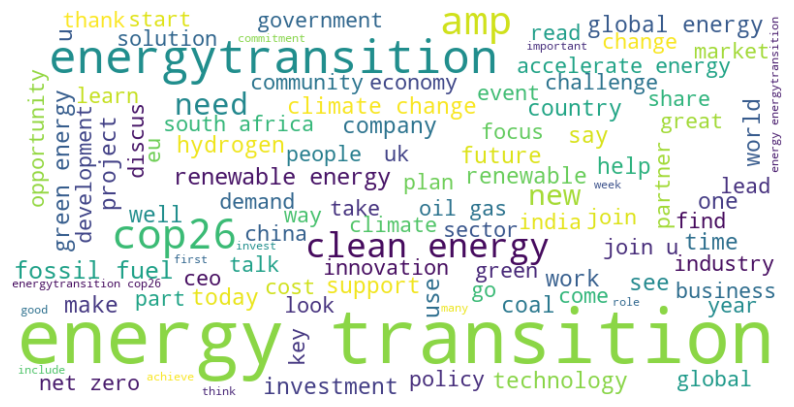

In [26]:
all_tokens = [token for tokens in tweet_df['Tweet'] for token in tokens]


wordcloud = WordCloud(max_words=100, 
                      width=800, 
                      height=400,
                      max_font_size=500,
                      background_color='white').generate_from_text(' '.join(all_tokens))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
#Removing  more stop words based on exploration of previuous word cloud.
stop_words_extra = {'energytransition','go','much','say', 'well', 'make', 'use', 'see', 'cop26', 'amp', 'look', 'come', 'way', 'many', 'amp', 'u', 'one', 'week', 'take'}

# Function to remove additional stopwords from tokens in each row
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words_extra]

# Apply the function to remove additional stopwords from the 'Tokens' column
tweet_df['Tweet'] = tweet_df['Tweet'].apply(remove_stopwords)

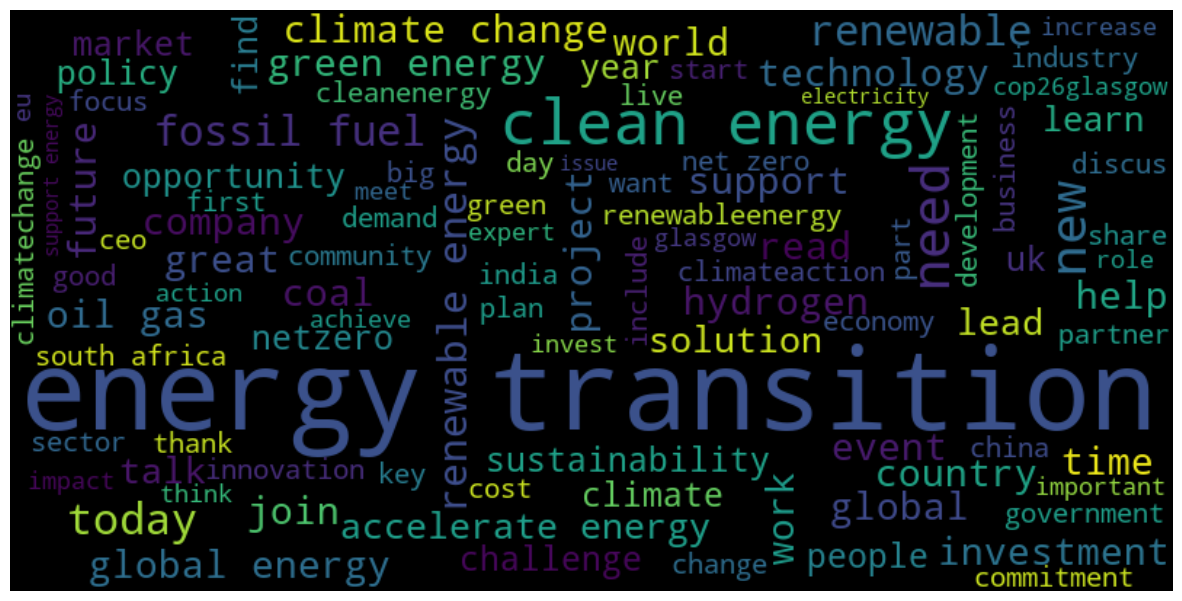

In [28]:
all_tokens2 = [token for tokens in tweet_df['Tweet'] for token in tokens]

wordcloud2= WordCloud(max_words=100, 
                      width=800, 
                      height=400,
                      max_font_size=500,
                      background_color='black').generate_from_text(' '.join(all_tokens2))

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

**Topic Modelling with LDA**

In [ ]:
# Create a list of tokenized tweets
token_list = tweet_df['Tweet'].tolist()

# Create a dictionary mapping tokens to IDs
dictionary = corpora.Dictionary(token_list)

# Convert tokenized tweets to bag-of-words format
bow_corpus = [dictionary.doc2bow(tokens) for tokens in token_list]

In [ ]:
num_topics = 7

lda_model = gensim.models.LdaMulticore(
        corpus=bow_corpus,
        id2word=dictionary,
        num_topics=num_topics
)